from .data_preprocess.video_process import sample_frame_indices

In [2]:
from decord import VideoReader, cpu
import torch
import numpy as np

In [3]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification
from huggingface_hub import hf_hub_download

2022-11-25 16:45:36.173268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 16:45:36.280595: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 16:45:36.732682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-25 16:45:36.732721: W tensorflow/

In [4]:
np.random.seed(0)

In [5]:
def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len

    indices = np.linspace(start_idx, end_idx, num = clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
print('file_path:',file_path)
file_path = '/projects/Task_871/sign_language/pytorchvideo_tutorial/archery.mp4'

videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 16 frames
videoreader.seek(0)
print(len(videoreader))
indices = sample_frame_indices(clip_len=70, frame_sample_rate=4, seg_len=len(videoreader))
print(indices)
video = videoreader.get_batch(indices).asnumpy()



In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
!git config --global credential.helper store

In [8]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 16 # batch size for training and evaluation

In [9]:

from huggingface_hub import hf_hub_download

hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id= hf_dataset_identifier, filename = filename, repo_type ="dataset"
)

In [25]:
print(file_path)

/root/.cache/huggingface/hub/datasets--sayakpaul--ucf101-subset/snapshots/942f12c657ae36848fe89c81342eb0527abf7630/UCF101_subset.tar.gz


In [26]:
!tar xf {file_path}

In [10]:
dataset_root_path = "/data/UCF101_subset"

!find {dataset_root_path} | head -5

/data/UCF101_subset
/data/UCF101_subset/train
/data/UCF101_subset/train/Basketball
/data/UCF101_subset/train/Basketball/v_Basketball_g09_c02.avi
/data/UCF101_subset/train/Basketball/v_Basketball_g21_c03.avi
find: ‘standard output’: Broken pipe
find: write error


In [11]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [12]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


In [13]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('/data/UCF101_subset/train/Basketball/v_Basketball_g09_c02.avi'),
 PosixPath('/data/UCF101_subset/train/Basketball/v_Basketball_g21_c03.avi'),
 PosixPath('/data/UCF101_subset/train/Basketball/v_Basketball_g19_c07.avi'),
 PosixPath('/data/UCF101_subset/train/Basketball/v_Basketball_g01_c03.avi'),
 PosixPath('/data/UCF101_subset/train/Basketball/v_Basketball_g22_c05.avi')]

In [14]:
class_labels = sorted({str(path).split("/")[4] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


In [15]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [17]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification


feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.3.intermediate.dense.bias', 'decoder.decoder_layers.3.attention.output.dense.weight', 'decoder.decoder_layers.2.attention.attention.v_bias', 'decoder.decoder_layers.1.attention.attention.q_bias', 'decoder.decoder_layers.3.attention.attention.key.weight', 'decoder.decoder_layers.2.attention.attention.value.weight', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.norm.bias', 'decoder.decoder_layers.1.attention.attention.key.weight', 'decoder.decoder_layers.3.attention.attention.v_bias', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.decoder_layers.0.layernorm_before.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.3.output.dense.bias', 'decoder.decoder_layers.3.layernorm_before.weight', 'decoder.decoder_layers.2.attention.attention.q_bias', 'decoder.head.weight', 'decoder.decoder

In [22]:
import os

mean = feature_extractor.image_mean
std = feature_extractor.image_std
resize_to = feature_extractor.size
print(resize_to)
num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

print(resize_to,clip_duration,num_frames_to_sample)
# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    #RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((resize_to, resize_to)),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

224
224 2.1333333333333333 16


In [20]:
train_dataset

In [21]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [ ]:
train_dataset.

In [47]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [48]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


In [49]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

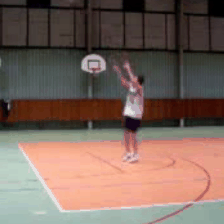

In [50]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [ ]:
del model
del trainer
torch.cuda.empty_cache()

In [37]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification


feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--MCG-NJU--videomae-base/snapshots/a2ecf56b81431c41c891939e878e95ad0fe0632d/preprocessor_config.json
Feature extractor VideoMAEFeatureExtractor {
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "VideoMAEFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "size": 224
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--MCG-NJU--videomae-base/snapshots/a2ecf56b81431c41c891939e878e95ad0fe0632d/config.json
Model config VideoMAEConfig {
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob

In [54]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4


In [55]:
batch_size = 8

In [ ]:

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub= False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

: 

: 

In [52]:
import evaluate

metric = evaluate.load("accuracy")

In [42]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [43]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [53]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

NameError: name 'Trainer' is not defined

In [45]:
train_results = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1184
  Num Epochs = 9223372036854775807
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 148
  Number of trainable parameters = 86234890


Epoch,Training Loss,Validation Loss,Accuracy
0,2.040200,1.863468,0.342857
1,0.846900,0.864763,0.714286
2,0.418900,0.563890,0.814286
3,0.203700,0.316870,0.942857


***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-ucf101-subset/checkpoint-38
Configuration saved in videomae-base-finetuned-ucf101-subset/checkpoint-38/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/checkpoint-38/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/checkpoint-38/preprocessor_config.json
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-ucf101-subset/checkpoint-76
Configuration saved in videomae-base-finetuned-ucf101-subset/checkpoint-76/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/checkpoint-76/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/checkpoint-76/preprocessor_config.json
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-ucf101-